In [85]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import xgboost
from lightgbm import LGBMRegressor

from sklearn.ensemble import BaggingRegressor

from mlxtend.evaluate import bias_variance_decomp

In [3]:
rawData = pd.read_csv("/Users/dilshod/Downloads/RussianBankDataCorr.csv", index_col=0)

In [4]:
rawData

,id,name,year,tip,pok,value
0,1,SBERBANK OF RUSSIA,2012,BIG,index,0.000000e+00
1,1,SBERBANK OF RUSSIA,2012,BIG,Assets,4.970714e+08
2,1,SBERBANK OF RUSSIA,2012,BIG,CIR,5.048000e+01
3,1,SBERBANK OF RUSSIA,2012,BIG,CoefficientOfAdequacyOfOwnCapital,1.370000e+01
4,1,SBERBANK OF RUSSIA,2012,BIG,DepositsAndShort-termFinancing,4.034643e+08
...,...,...,...,...,...,...
29541,315,SINERGIYA OAO,2017,NANO,Data,2.017000e+03
29542,315,SINERGIYA OAO,2017,NANO,DEP,4.868145e-01
29543,315,SINERGIYA OAO,2017,NANO,TAssets,9.879656e+00
29544,315,SINERGIYA OAO,2017,NANO,NIM,1.080000e+01


In [5]:
data = rawData.drop(columns=['id', 'tip']).pivot_table(index=['name', 'year'], columns='pok', values='value').reset_index()

In [6]:
data['name'] = data['name'] + " " + data['year'].astype(str)
data = data.rename_axis(None, axis=1)
data = data.drop(columns=['year', 'Data', 'index'])
data = data.sort_values(by=['TAssets'], ascending=False)
data = data.dropna()

In [7]:
data = data.set_index(np.arange(len(data)))

In [8]:
data

,name,Assets,CAR,CIR,CoefficientOfAdequacyOfOwnCapital,DEP,DepositsAndShort-termFinancing,InterestIncome,LOAN,NII,NIM,NetInterestMargin,OOD,OtherOperatingIncome,ROA,ROE,RQA,TAssets,Tier1
0,SBERBANK OF RUSSIA 2013,556393068.0,13.40,45.73,13.40,0.819575,456005646.0,45176784.0,71.02,0.144725,5.97,5.97,583577.0,7644550.0,2.17,20.66,4.51,20.136986,10.60
1,SBERBANK OF RUSSIA 2012,497071356.0,13.70,50.48,13.70,0.811683,403464273.0,38103295.0,69.54,0.172411,6.44,6.44,1293925.0,7938049.0,2.68,24.06,5.11,20.024244,10.40
2,SBERBANK OF RUSSIA 2020,487521621.0,14.70,36.24,14.70,0.760626,370821539.0,32477527.0,64.93,0.209821,5.43,5.43,1784078.0,8623946.0,2.30,15.95,6.49,20.004845,14.30
3,SBERBANK OF RUSSIA 2019,483957068.0,14.80,37.73,14.80,0.747250,361637148.0,38704030.0,67.97,0.198045,5.41,5.41,297226.0,9558086.0,2.76,20.26,6.37,19.997507,14.50
4,SBERBANK OF RUSSIA 2017,470696273.0,13.00,35.23,13.00,0.782648,368389338.0,37003343.0,68.19,0.192468,5.81,5.81,1397565.0,8819414.0,2.73,22.87,7.05,19.969724,11.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BANK STANDARD-CREDIT 2020,9509.0,40.92,107.30,40.92,0.668314,6355.0,841.0,42.73,0.152218,10.16,10.16,-43.0,151.0,-3.89,-12.01,3.80,9.159994,30.70
996,BANK STANDARD-CREDIT 2018,9088.0,40.60,161.08,40.60,0.478983,4353.0,950.0,42.37,0.133212,10.93,10.93,133.0,146.0,-5.21,-12.93,14.81,9.114710,32.00
997,NATIONAL SAVINGS BANK 2016,7943.0,8.00,100.04,8.00,0.275589,2189.0,614.0,37.34,0.223767,10.57,10.57,123.0,177.0,-8.55,-12.46,25.08,8.980046,6.00
998,"JSC RNCO ""KHOLMSK 2020",7372.0,37.43,125.41,37.43,0.780792,5756.0,129.0,3.80,0.857459,0.93,0.93,294.0,776.0,-1.38,-6.60,2.41,8.905444,15.08


In [ ]:
# how to find Non Interest Income

In [ ]:
# DEP, Price -> LOAN, NII, Revenue (II + OtherOperInc) !!!!!!!
# orient "in"

In [15]:
data['Revenue'] = data['InterestIncome'] + data['OtherOperatingIncome']
data['Cost'] = (data['CIR'] / 100) *  data['Revenue']
data['Price'] = data['Cost'] / (data['DEP'] * data['Assets'])

In [16]:
data

,name,Assets,CAR,CIR,CoefficientOfAdequacyOfOwnCapital,DEP,DepositsAndShort-termFinancing,InterestIncome,LOAN,NII,...,OOD,OtherOperatingIncome,ROA,ROE,RQA,TAssets,Tier1,Revenue,Cost,Price
0,SBERBANK OF RUSSIA 2013,556393068.0,13.40,45.73,13.40,0.819575,456005646.0,45176784.0,71.02,0.144725,...,583577.0,7644550.0,2.17,20.66,4.51,20.136986,10.60,52821334.0,2.415520e+07,0.052971
1,SBERBANK OF RUSSIA 2012,497071356.0,13.70,50.48,13.70,0.811683,403464273.0,38103295.0,69.54,0.172411,...,1293925.0,7938049.0,2.68,24.06,5.11,20.024244,10.40,46041344.0,2.324167e+07,0.057605
2,SBERBANK OF RUSSIA 2020,487521621.0,14.70,36.24,14.70,0.760626,370821539.0,32477527.0,64.93,0.209821,...,1784078.0,8623946.0,2.30,15.95,6.49,20.004845,14.30,41101473.0,1.489517e+07,0.040168
3,SBERBANK OF RUSSIA 2019,483957068.0,14.80,37.73,14.80,0.747250,361637148.0,38704030.0,67.97,0.198045,...,297226.0,9558086.0,2.76,20.26,6.37,19.997507,14.50,48262116.0,1.820930e+07,0.050352
4,SBERBANK OF RUSSIA 2017,470696273.0,13.00,35.23,13.00,0.782648,368389338.0,37003343.0,68.19,0.192468,...,1397565.0,8819414.0,2.73,22.87,7.05,19.969724,11.40,45822757.0,1.614336e+07,0.043821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BANK STANDARD-CREDIT 2020,9509.0,40.92,107.30,40.92,0.668314,6355.0,841.0,42.73,0.152218,...,-43.0,151.0,-3.89,-12.01,3.80,9.159994,30.70,992.0,1.064416e+03,0.167493
996,BANK STANDARD-CREDIT 2018,9088.0,40.60,161.08,40.60,0.478983,4353.0,950.0,42.37,0.133212,...,133.0,146.0,-5.21,-12.93,14.81,9.114710,32.00,1096.0,1.765437e+03,0.405568
997,NATIONAL SAVINGS BANK 2016,7943.0,8.00,100.04,8.00,0.275589,2189.0,614.0,37.34,0.223767,...,123.0,177.0,-8.55,-12.46,25.08,8.980046,6.00,791.0,7.913164e+02,0.361497
998,"JSC RNCO ""KHOLMSK 2020",7372.0,37.43,125.41,37.43,0.780792,5756.0,129.0,3.80,0.857459,...,294.0,776.0,-1.38,-6.60,2.41,8.905444,15.08,905.0,1.134960e+03,0.197179


In [17]:
dea_features = data[['name', 'DEP', 'Price', 'LOAN', 'NII', 'Revenue']]

In [18]:
dea_features

,name,DEP,Price,LOAN,NII,Revenue
0,SBERBANK OF RUSSIA 2013,0.819575,0.052971,71.02,0.144725,52821334.0
1,SBERBANK OF RUSSIA 2012,0.811683,0.057605,69.54,0.172411,46041344.0
2,SBERBANK OF RUSSIA 2020,0.760626,0.040168,64.93,0.209821,41101473.0
3,SBERBANK OF RUSSIA 2019,0.747250,0.050352,67.97,0.198045,48262116.0
4,SBERBANK OF RUSSIA 2017,0.782648,0.043821,68.19,0.192468,45822757.0
...,...,...,...,...,...,...
995,BANK STANDARD-CREDIT 2020,0.668314,0.167493,42.73,0.152218,992.0
996,BANK STANDARD-CREDIT 2018,0.478983,0.405568,42.37,0.133212,1096.0
997,NATIONAL SAVINGS BANK 2016,0.275589,0.361497,37.34,0.223767,791.0
998,"JSC RNCO ""KHOLMSK 2020",0.780792,0.197179,3.80,0.857459,905.0


In [21]:
dea = EnvelopDEA(frontier="CRS", orient="in")
dea.fit(inputs=dea_features[['DEP', 'Price']].to_numpy(), outputs=dea_features[['LOAN', 'NII', 'Revenue']].to_numpy())

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_b/f62_3kh151x02tlww4dcpdtr0000gn/T/431c74d1f8154aa0a380c6da17ce25c4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/_b/f62_3kh151x02tlww4dcpdtr0000gn/T/431c74d1f8154aa0a380c6da17ce25c4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 5014 RHS
At line 5020 BOUNDS
At line 5021 ENDATA
Problem MODEL has 5 rows, 1001 columns and 5002 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 5 (0) rows, 1001 (0) columns and 5002 (0) elements
Perturbing problem by 0.001% of 23.452722 - largest nonzero change 1.0155998e-05 ( 4.3304135e-05%) - largest zero change 1.0153985e-05
0  Obj 0 Primal inf 559.61212 (3)
7  Obj 1.0001112
Optimal - objective value 1
Optimal objective 1 - 7 iterations time 0.002

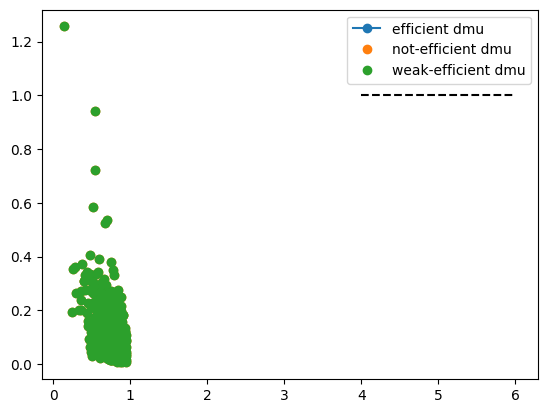

In [22]:
eff_dmu = [r.dmu for r in dea.result if r.is_efficient]
ineff_dmu = [r.dmu for r in dea.result if r.is_efficient != 1]
weak_eff_dmu = [r.dmu for r in dea.result if r.has_slack]

plt.figure()
plt.plot(
    [d.input[0] for d in eff_dmu],
    [d.input[1] for d in eff_dmu],
    "-o",
    label="efficient dmu",
)
plt.plot(
    [d.input[0] for d in ineff_dmu],
    [d.input[1] for d in ineff_dmu],
    "o",
    label="not-efficient dmu",
)
plt.plot(
    [d.input[0] for d in weak_eff_dmu],
    [d.input[1] for d in weak_eff_dmu],
    "o",
    label="weak-efficient dmu",
)
plt.plot([4, 6], [1, 1], linestyle="--", color="black")
plt.legend()
plt.show()

In [23]:
scores = np.array([r.score for r in dea.result])

In [24]:
dea_features.insert(len(dea_features.columns), 'Score', scores)

In [25]:
dea_features

,name,DEP,Price,LOAN,NII,Revenue,Score
0,SBERBANK OF RUSSIA 2013,0.819575,0.052971,71.02,0.144725,52821334.0,1.000000
1,SBERBANK OF RUSSIA 2012,0.811683,0.057605,69.54,0.172411,46041344.0,0.909176
2,SBERBANK OF RUSSIA 2020,0.760626,0.040168,64.93,0.209821,41101473.0,1.000000
3,SBERBANK OF RUSSIA 2019,0.747250,0.050352,67.97,0.198045,48262116.0,1.000000
4,SBERBANK OF RUSSIA 2017,0.782648,0.043821,68.19,0.192468,45822757.0,1.000000
...,...,...,...,...,...,...,...
995,BANK STANDARD-CREDIT 2020,0.668314,0.167493,42.73,0.152218,992.0,0.332510
996,BANK STANDARD-CREDIT 2018,0.478983,0.405568,42.37,0.133212,1096.0,0.260325
997,NATIONAL SAVINGS BANK 2016,0.275589,0.361497,37.34,0.223767,791.0,0.471852
998,"JSC RNCO ""KHOLMSK 2020",0.780792,0.197179,3.80,0.857459,905.0,0.828158


In [34]:
# now we have dea scores for each dmu

In [26]:
X = dea_features[['DEP', 'Price', 'LOAN', 'NII', 'Revenue']]
Y = dea_features['Score']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=98987)

In [28]:
best_scores = {}

In [29]:
parameters = {
    "learning_rate": (0.001, 0.01, ),
    "max_depth": [ 2, 4],
    "min_child_weight": [ 1, 10],
    "gamma":[ 0.0,],
    "n_estimators": [1000, 5000]
}
xgb = xgboost.XGBRegressor()
xgb_gs = GridSearchCV(xgb, parameters, verbose=2, cv=3)
xgb_gs.fit(x_train, y_train);

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=1000; total time=   0.8s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=1000; total time=   0.5s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=1000; total time=   0.5s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=5000; total time=   3.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=5000; total time=   3.9s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=5000; total time=   2.7s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=10, n_estimators=1000; total time=   0.5s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=10, n_estimators=1000; total time=   0.6s
[CV] END gamma=0.0, learning_rate=0.001, 

In [30]:
print(xgb_gs.best_params_)
best_scores["XGBoost"] = np.abs(xgb_gs.predict(x_test) - y_test)

{'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5000}


In [31]:
parameters = {
    'num_leaves': (40, 20, 10,),
    'learning_rate': (0.1, 0.01, 0.05),
    'max_depth': (-1,),
    'n_estimators': (10**3, 10**4),}

lgbmr_gs = GridSearchCV(LGBMRegressor(), parameters, verbose=2)
lgbmr_gs.fit(x_train, y_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total ti

In [32]:
print(lgbmr_gs.best_params_)
best_scores["LightGBM"] = np.abs(lgbmr_gs.predict(x_test) - y_test)

{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 10000, 'num_leaves': 10}


In [33]:
np.sum(best_scores["LightGBM"]), np.sum(best_scores["XGBoost"])

(3.471053001606038, 2.3043094314126966)

In [ ]:
# lightgbm показал лучше результаты

In [34]:
best_scores["LightGBM"]

459    0.014022
618    0.007869
553    0.078124
424    0.006968
21     0.004878
         ...   
770    0.031588
715    0.013859
207    0.007757
560    0.000209
428    0.040373
Name: Score, Length: 100, dtype: float64

In [143]:
bp_xgbst = xgboost.XGBRegressor(**xgb_gs.best_params_)
bp_lgm = LGBMRegressor(**lgbmr_gs.best_params_)

In [150]:
mse_xg, bias_xg, var_xg = bias_variance_decomp(bp_xgbst, x_train.values, y_train.values, x_test.values, y_test.values, num_rounds=50, loss='mse')

In [151]:
mse_xg, bias_xg, var_xg

(0.004622097146489129, 0.004040973781974984, 0.0005811233645141458)

In [153]:
mse_lgm, bias_lgm, var_lgm = bias_variance_decomp(bp_lgm, x_train.values, y_train.values, x_test.values, y_test.values, num_rounds=50, loss='mse')

In [154]:
mse_lgm, bias_lgm, var_lgm

(0.004520426106490394, 0.0038409006679697368, 0.0006795254385206579)

In [41]:
parameters = {
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
}
rfc = RandomForestRegressor(random_state=42)
rfc_cv = GridSearchCV(estimator=rfc, param_grid=parameters, cv=5, verbose=2)
rfc_cv.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.7s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.6s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.8s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.7s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.7s
[CV] END ......................max_depth=4, n_estimators=500; total time=   1.6s
[CV] END ......................max_depth=4, n_estimators=500; total time=   1.8s
[CV] END ......................max_depth=4, n_estimators=500; total time=   1.5s
[CV] END ......................max_depth=4, n_estimators=500; total time=   1.9s
[CV] END ......................max_depth=4, n_estimators=500; total time=   1.9s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.9s
[CV] END ......................max_depth=5, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]},
             verbose=2)

In [42]:
print(rfc_cv.best_params_)
best_scores["RandomForest"] = np.abs(rfc_cv.predict(x_test) - y_test)

{'max_depth': 8, 'n_estimators': 500}


In [48]:
np.sum(best_scores["LightGBM"]), np.sum(best_scores["XGBoost"]), np.sum(best_scores["RandomForest"])

(3.471053001606038, 2.3043094314126966, 4.127530028276926)

In [49]:
y_test

459    0.300705
618    0.421262
553    0.706541
424    0.452490
21     0.699253
         ...   
770    0.327957
715    0.368243
207    0.650015
560    0.402529
428    0.524423
Name: Score, Length: 100, dtype: float64

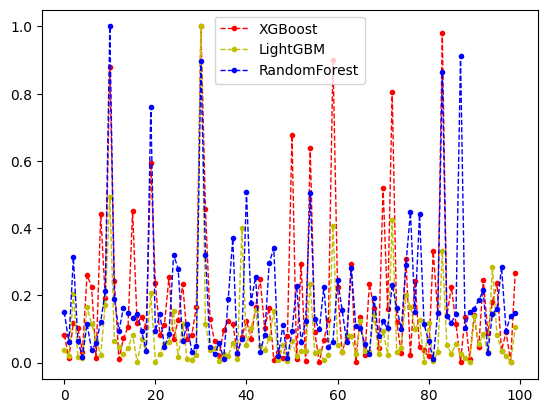

In [116]:
plt.plot(np.arange(y_test.size), np.abs(xgb_gs.predict(x_test) - y_test) / np.max(np.abs(xgb_gs.predict(x_test) - y_test)), "r.--", label='XGBoost', lw=1)
plt.plot(np.arange(y_test.size), np.abs(lgbmr_gs.predict(x_test) - y_test) / np.max(np.abs(lgbmr_gs.predict(x_test) - y_test)), "y.--", label='LightGBM', lw=1)
plt.plot(np.arange(y_test.size), np.abs(rfc_cv.predict(x_test) - y_test) / np.max(np.abs(rfc_cv.predict(x_test) - y_test)), 'b.--', label='RandomForest', lw=1)

plt.legend()

(0.9506264479704937, 0.8510617396282245, 0.8575174174273026)

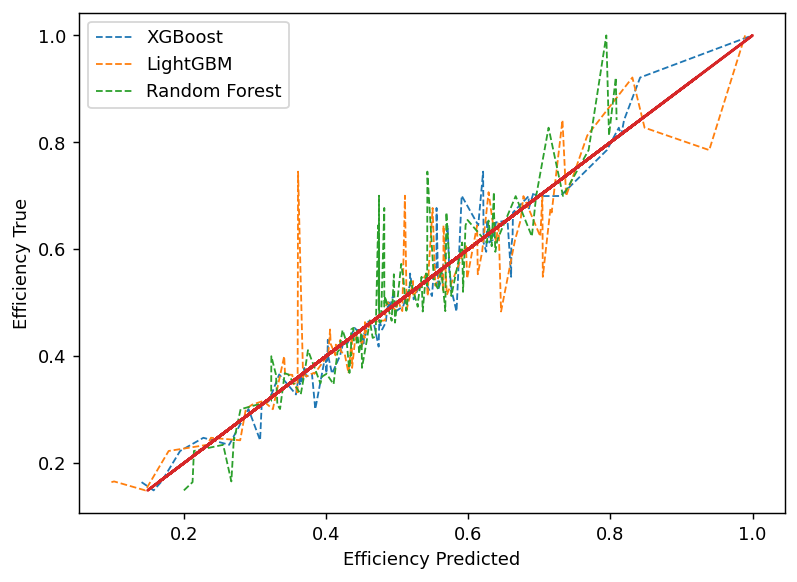

In [115]:
fig = plt.figure(figsize=(7, 5), dpi=130)

order_xgm = np.argsort(xgb_gs.predict(x_test))
order_lbgm = np.argsort(lgbmr_gs.predict(x_test))
order_rnf = np.argsort(rfc_cv.predict(x_test))

plt.plot(xgb_gs.predict(x_test)[order_xgm], y_test.to_numpy()[order_xgm], '--', label=f'XGBoost', lw=1)
plt.plot(lgbmr_gs.predict(x_test)[order_lbgm], y_test.to_numpy()[order_lbgm], '--', label='LightGBM', lw=1)
plt.plot(rfc_cv.predict(x_test)[order_rnf], y_test.to_numpy()[order_rnf], '--', label='Random Forest', lw=1)

plt.plot(y_test, y_test)

plt.xlabel("Efficiency Predicted")
plt.ylabel("Efficiency True")
plt.title('')

plt.legend()

r2_score(y_test, xgb_gs.predict(x_test)), r2_score(y_test, lgbmr_gs.predict(x_test)), r2_score(y_test, rfc_cv.predict(x_test))